In [29]:
import os
import time
import pickle
import numpy as np
import scipy.stats
import sys
import random
from sklearn.datasets import make_s_curve
import importlib
import functions
importlib.reload(functions)
import sklearn
import multiprocess as mp
import tqdm
import torch
from scipy.spatial.distance import pdist, squareform
import math
import flexcode
import matplotlib.pyplot as plt
from flexcode.regression_models import NN # for univariate response data Y

## PCP-VCR Example with S-shape data 
### Overview
* Step 1 **Data Splitting:** Generate data $(X,Y)$, then split the data into train/calibration/test splits
* Step 2 **Model Training:** Use training data to train a conditional generative model of interest (conditional VAE, conditional GAN, Kernel Mixture Network, etc). Here we implement the nearest neighbors regression to estimate the conditional density with ***Flexcode*** package.
* Step 3 **Sampling and Ranking:** Generate *n_sample=10* conditional random samples from the fitted model on training data to visually check the model performance.
* Step 4 **Optimization Approximation:** Approximate the optimization solution with the proposed efficient approximation algorithm.
* Step 5 **Evaluate Coverage and  Efficiency:** Evaluate the empirical coverage rate and efficiency of coverage set on testing data. 

In [30]:
##### Data generation and splitting 
n = 5000; n_sample = 10
x, t = make_s_curve(n_samples=n,noise=0)
X= x[:,0].reshape(n,1);Y=x[:,2].reshape(n,1)
train,calib,test = np.split(range(n),[int(.6*n),int(.8*n),])
print(f'train size: {len(train)}, calib size: {len(calib)}, test size: {len(test)}')

##### Data training 
model = flexcode.FlexCodeModel(NN, max_basis=31, basis_system="cosine",regression_params={"k":50})
# Fit and tune model
train,validate = np.split(range(len(train)),[int(.9*len(train)),])
model.fit(X[train], Y[train])
model.tune(X[validate], Y[validate])

##### Generate some random samples on training data from the fitted model for visualization
cdes, y_grid = model.predict(X[np.concatenate((train,validate))], n_grid=100)
normalized_probs = cdes / cdes.sum(axis=1, keepdims=True)  # Normalize probabilities once
Y_sampled = y_grid[np.array([
    np.random.choice(len(y_grid), size=n_sample, p=probs) for probs in normalized_probs
])]
print('conditional random samples size on training data: ',Y_sampled.shape)

train size: 3000, calib size: 1000, test size: 1000
conditional random samples size on training data:  (3000, 10, 1)


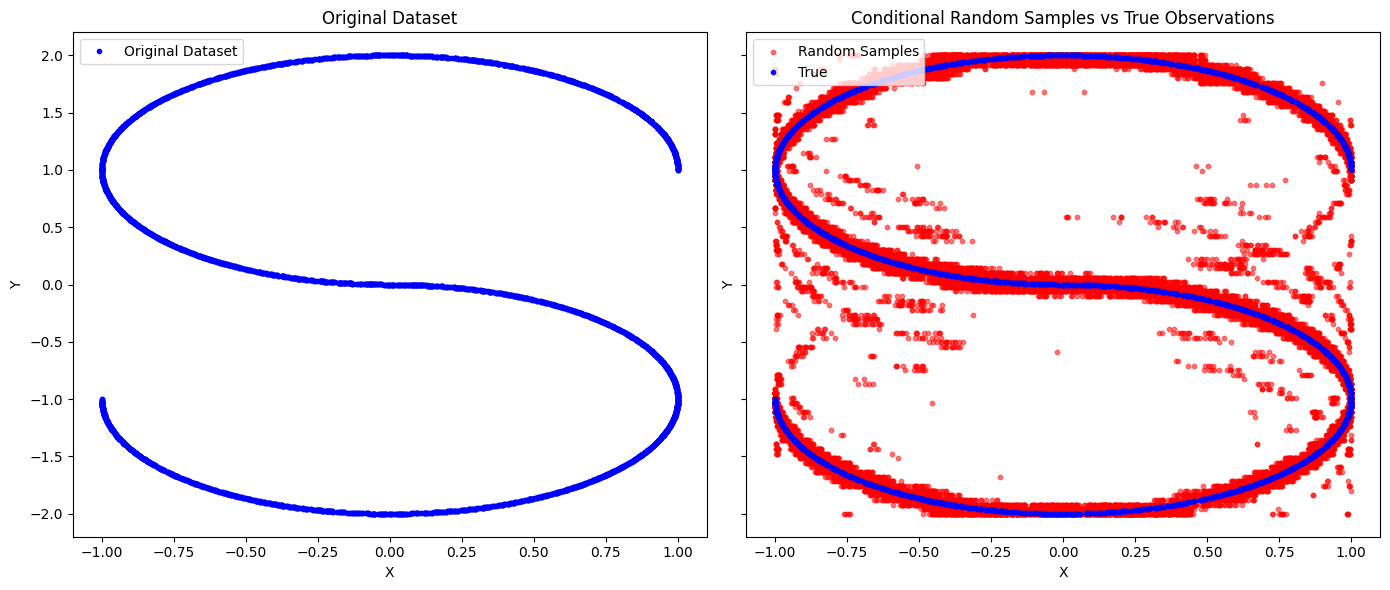

In [24]:
#### visualize the results and random samples
fig, axs = plt.subplots(1, 2, figsize=(14, 6),sharex=True,sharey=True)
# Plot the original dataset
axs[0].plot(X, Y, '.', color='blue', label='Original Dataset')
axs[0].set_title("Original Dataset")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].legend(loc='upper left')

# Plot the conditional random samples and true observations on training data
axs[1].scatter(
    X[np.concatenate((train, validate))].repeat(Y_sampled.shape[1]),
    Y_sampled.flatten(),
    alpha=0.5, s=10, label='Random Samples', color='red'
)
axs[1].plot(
    X[np.concatenate((train, validate))],
    Y[np.concatenate((train, validate))], '.', label='True',color='blue'
)
axs[1].set_title("Conditional Random Samples vs True Observations")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
# Generate random samples for calibration and testing data
cdes, y_grid = model.predict(X[np.concatenate((calib, test))], n_grid=100)
normalized_probs = cdes / cdes.sum(axis=1, keepdims=True)  # Normalize probabilities once
Y_hat = y_grid[np.array([
    np.random.choice(len(y_grid), size=n_sample, p=probs) for probs in normalized_probs
])]
print('Conditional random samples size on calibration & testing data: ',Y_hat.shape)

# Ranking the samples by their average m-nearest neighbor distances, here we pick m=4.
# Compute pairwise distances between Y and Y_hat_ranked. Each row is a non-conformity score vector.
pcp_vcr = functions.PCP_VCR(n_sample_K = n_sample,alpha=0.1,y_dim = Y.shape[1])
Y_cal_test = Y[np.concatenate((calib, test))].reshape(-1,1,pcp_vcr.y_dim)
Y_hat_ranked = pcp_vcr.rank(Y_cal_test,Y_hat,k_neighbor = 4)
dist_matrix = pcp_vcr.compute_dist_matrix(Y_cal_test,Y_hat)
dist_matrix_rank = pcp_vcr.compute_dist_matrix(Y_cal_test,Y_hat_ranked)

Conditional random samples size on calibration & testing data:  (2000, 10, 1)


In [33]:
# Approximate algorithm on calibration data: initialize different entries in range(n_sample), and select the approximated solution with the best approximated efficiency (sum of prediction regions, no consideration of overlap).
E_q_list = []
radius_list = []
time_list = []
for pos in range(n_sample):
    start_time = time.time()
    E_q = pcp_vcr.calibrate(dist_matrix_rank[:len(calib),:],num_iter = 300,position=pos)
    end_time = time.time()
    time_list.append(end_time-start_time)
    radius = np.sum(E_q ** pcp_vcr.y_dim)
    E_q_list.append(E_q)
    radius_list.append(radius)
    
# Compute the empirical coverage and exact empirical efficiency (with consideration of overlap) on testing data.  
# get_coverage_length_overlap function is used to compute the exact efficiency of the coverage set, but this is only computable in 1-dim data. For higher dimensions, there is no analytical solution other than Monte Carlo. 
pcp_vcr_radius = E_q_list[np.argmin(radius_list)]
emp_coverage = pcp_vcr.empirical_coverage(dist_matrix_rank[len(calib):,:],pcp_vcr_radius)
print(f"PCP-VCR empirical coverage: {emp_coverage:.3f}")
rank_pcp_exact_length = functions.get_coverage_length_overlap(pcp_vcr_radius,Y_hat_ranked[len(calib):])
print(f"PCP-VCR empirical efficiency: {np.mean(rank_pcp_exact_length):.3f}")

PCP-VCR empirical coverage: 0.902
PCP-VCR empirical efficiency: 0.511


In [35]:
# Compare with results of PCP.  
pcp_radius = pcp_vcr.pcp_radius(dist_matrix[:len(calib)])
pcp_coverage = pcp_vcr.empirical_coverage(dist_matrix[len(calib):],pcp_radius)
pcp_exact_length = functions.get_coverage_length_overlap(pcp_radius,Y_hat[len(calib):])
print(f"PCP-VCR empirical coverage: {pcp_coverage:.3f}")
print(f"PCP-VCR empirical efficiency: {np.mean(pcp_exact_length):.3f}")

PCP-VCR empirical coverage: 0.903
PCP-VCR empirical efficiency: 0.553
